# Process Mining in Healthcare

In recent years, the systematisation of healthcare operations and the digitisation of medical records have led to the collection of an increasing amount of data from complex clinical processes. Additionally, there has been increasing interest in process optimisation and process debugging approaches to improve the effectiveness and quality of healthcare. These methods have been used to:

* identify processes, then describe them using process models. Such models can be represented using a variety of graphical languages, including Petri nets, direct-sequence graphs and business process models;

* examine the throughput and time spent on each event to discover bottlenecks and possibilities for improving efficiency;

* analyse the correspondence of actual procedures with recommended treatment practices and paths.

In [1]:
# Import the libraries:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset:
events = pd.read_csv('Dataset.csv')
events.columns = ['patient', 'action', 'resource', 'datetime']
events['datetime'] = pd.to_datetime(events['datetime'])

# View the dataset:
print('The dataset has {} rows and {} columns.'.format(events.shape[0], events.shape[1]))
events.head()

The dataset has 690 rows and 4 columns.


,patient,action,resource,datetime
0,patient 0,First consult,Dr. Anna,2017-01-02 11:40:11
1,patient 0,Blood test,Lab,2017-01-02 12:47:33
2,patient 0,Physical test,Nurse Jesse,2017-01-02 12:53:50
3,patient 0,Second consult,Dr. Anna,2017-01-02 16:21:06
4,patient 0,Surgery,Dr. Charlie,2017-01-05 13:23:09


Let us consider that our aim is to better understand the various patient paths. In this instance, cases would be associated with the patient column, events with the action column and resources with the resource column (but if the goal were different, we could choose a different mapping, for example we could treat the resource column as a case, if we were studying processes from the point of view of doctors rather than patients).

## Data Analysis

The calculation of the relative time of each event, that is the time at which the event occurs concerning the start of the process, is the first step in creating the event log.

In [2]:
# Create a pivot table containing the start (minimum) and end (maximum) times for each case:
case_starts_ends = events.pivot_table(index='patient', aggfunc={'datetime': ['min', 'max']})
case_starts_ends = case_starts_ends.reset_index()
case_starts_ends.columns = ['patient', 'case_end', 'case_start']

# Merge the main event log data, so that each line contains start and end times:
events = events.merge(case_starts_ends, on='patient')

# Subtract the process start time from the event timestamp to determine the relative time:
events['relativetime'] = events['datetime'] - events['case_start']
events['relativetime_seconds'] = events['relativetime'].dt.seconds + 86400*events['relativetime'].dt.days
events['relativetime_days'] = events['relativetime'].dt.days

It is useful to visualise the events linked to each example in relative time to get a general idea of how the process appears. For this purpose, one can use a dot plot, which graphs the sequences of events of each instance against time.

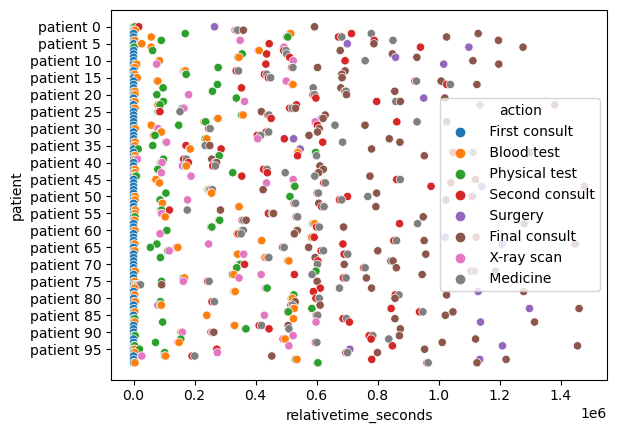

In [3]:
# Obtain a set of labels for the y-axis to label the graph:
patient_nums = [int(e) for e in events['patient'].apply(lambda x: x.strip('patient'))]

# For greater readability, set the y-axis ticks, so that only one patient out of five is displayed:
plt.yticks(np.arange(min(patient_nums), max(patient_nums)+1, 5))

# Create a scatter plot showing the occurrences of patients with time:
sns.scatterplot(x=events['relativetime_seconds'], y=events['patient'], hue=events['action'])
plt.show()

It is difficult to read. We should arrange the examples according to total process durations, so that the graph is easier to read. It also improves the understanding of the distribution of process durations.

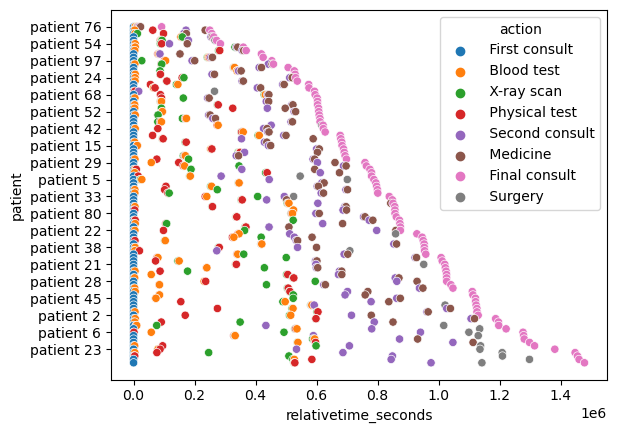

In [4]:
# Sort by case length:
events['case_length'] = events['case_end'] - events['case_start']
ordered = events.sort_values(by=['case_length', 'patient', 'relativetime_seconds'])
plt.yticks(np.arange(min(patient_nums), max(patient_nums)+1, 5))
sns.scatterplot(x=ordered['relativetime_seconds'], y=ordered['patient'], hue=ordered['action'])
plt.show()

The dotted graph can also be used to determine the trend of events in absolute time, for example if instances arrive often or if there are trends on a weekly/daily basis.

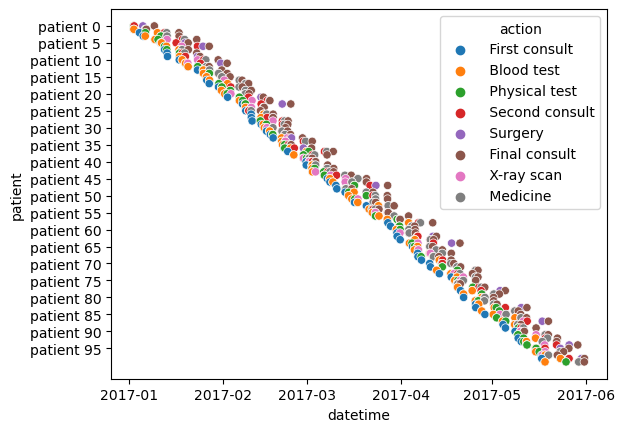

In [5]:
plt.yticks(np.arange(min(patient_nums), max(patient_nums)+1, 5))
sns.scatterplot(x=events['datetime'], y=events['patient'], hue=events['action'])
plt.show()

This shows a continuous influx of requests. Tracing events with resources also makes it possible to analyse events with resources.

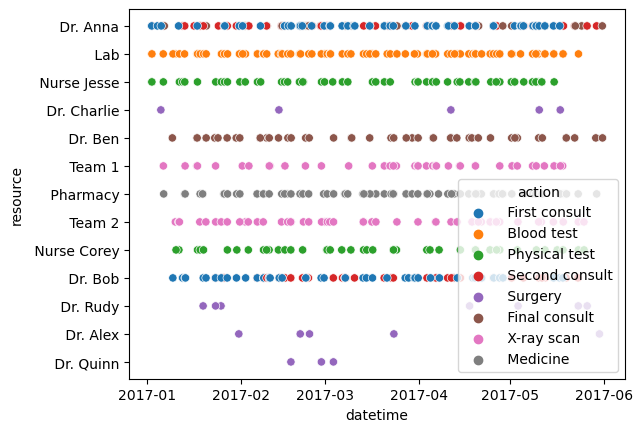

In [6]:
sns.scatterplot(x=events['datetime'], y=events['resource'], hue=events['action'])
plt.show()

Schedules must first be converted to days of the week to observe weekly trends.

In [7]:
events['weekday'] = events['datetime'].apply(lambda x: x.weekday())

This time, a jitter graph is preferable to a strip chart because the x-axis (day of the week) is categorical.

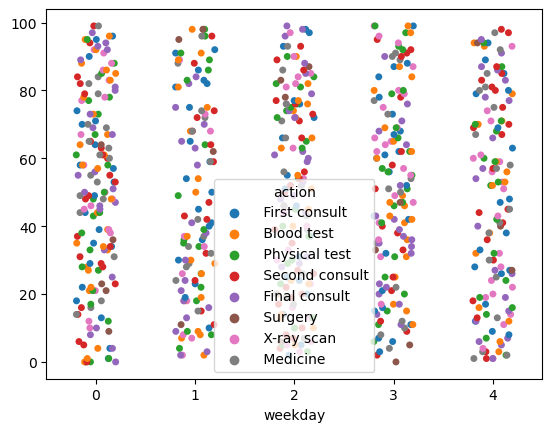

In [8]:
sns.stripplot(x=events['weekday'], y=patient_nums, hue=events['action'], jitter=0.2)
plt.show()

Another thing to consider is which events are shared by all tasks and which are not, since in process mining we are interested in distinctive events that are not shared.

The following actions are common to all cases:  Blood test,  Final consult,  First consult,  Physical test,  Second consult
The following actions are the ones that we wish to keep (not common to all cases):  Medicine,  Surgery,  X-ray scan


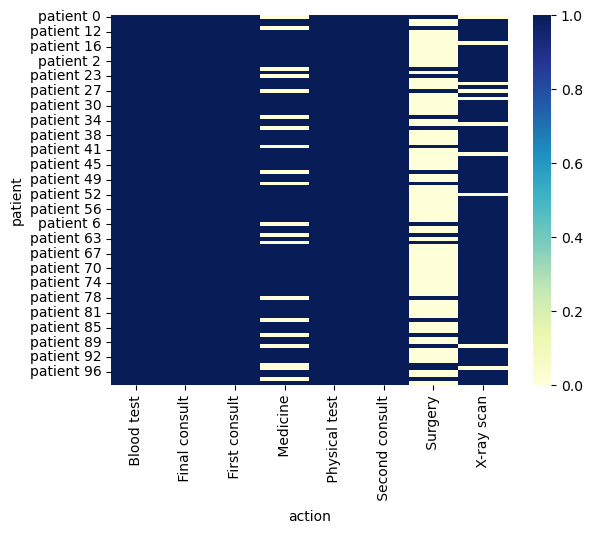

In [9]:
# Prepare a table listing the cases in which each event occurs:
patient_events = pd.crosstab(events['patient'], events['action'])

# Determine the number of distinct event counts (if an event is shared by all patients, this value must be set to 1):
n_unique = patient_events.apply(pd.Series.nunique)
shared_actions = n_unique[n_unique==1].index 
kept_actions = n_unique[n_unique>1].index 
print('The following actions are common to all cases: {}'.format(', '.join(shared_actions))) 
print('The following actions are the ones that we wish to keep (not common to all cases): {}'.format(', '.join(kept_actions)))

# Plot in a heat map:
sns.heatmap(patient_events, cmap="YlGnBu")
plt.show()

First consult, blood test, second consult, physical test and final consult are the events shared by all patients, while medicine, surgery and x-ray scan are the differentiating events.

## Process Discovery

We need to map:

* the "patient" to the case, which is represented by the label "case:concept:name" in PM4Py;

* the "datetime" to the timestamp, which is represented by the label "time:timestamp" in PM4Py;

* the "action" to the event, which is represented by the label "concept:name" in PM4Py;

* the "resource" to the resource, which is represented by the label "org:resource" in PM4Py.

In [10]:
from pm4py.objects.conversion.log import converter as log_converter
events.rename(columns={'datetime': 'time:timestamp', 'patient': 'case:concept:name', 'action': 'concept:name', 'resource': 'org:resource'}, inplace=True)
log = log_converter.apply(events)

Let us now begin using the PM4Py library to implement process discovery with the inductive miner. Inductive mining, like heuristic mining, ignores low-frequency events, isolated events and event loops. It also ensures soundness as an improvement in heuristics mining and alpha mining. Being solid indicates that the process model will always be safe, complete correctly and have the possibility of choosing to terminate, as well as that at least one of the process events will be executed. Therefore, a workflow network must fulfil the following criteria to be considered solid:

* safety;

* correct completion;

* possibility of termination;

* absence of dead parts.

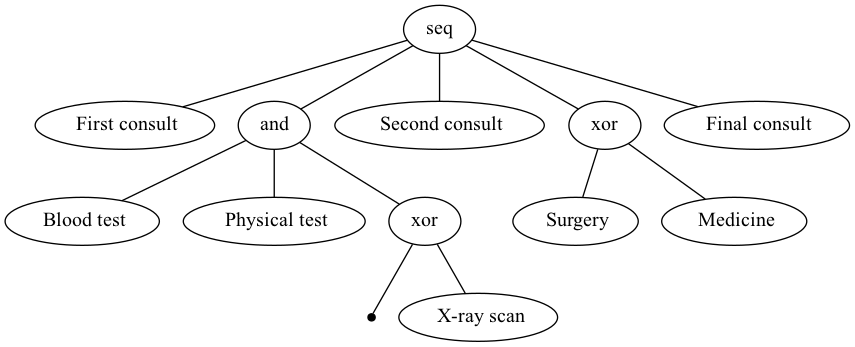

In [11]:
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.visualization.process_tree import visualizer as pt_visualiser
process_tree = inductive_miner.apply(log)
graph_visualisation = pt_visualiser.apply(process_tree)
pt_visualiser.view(graph_visualisation)
pt_visualiser.save(graph_visualisation, 'ProcessTree.png')

The corresponding Petri net representation can also be found, even if the process tree is the default internal representation of the process model.

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

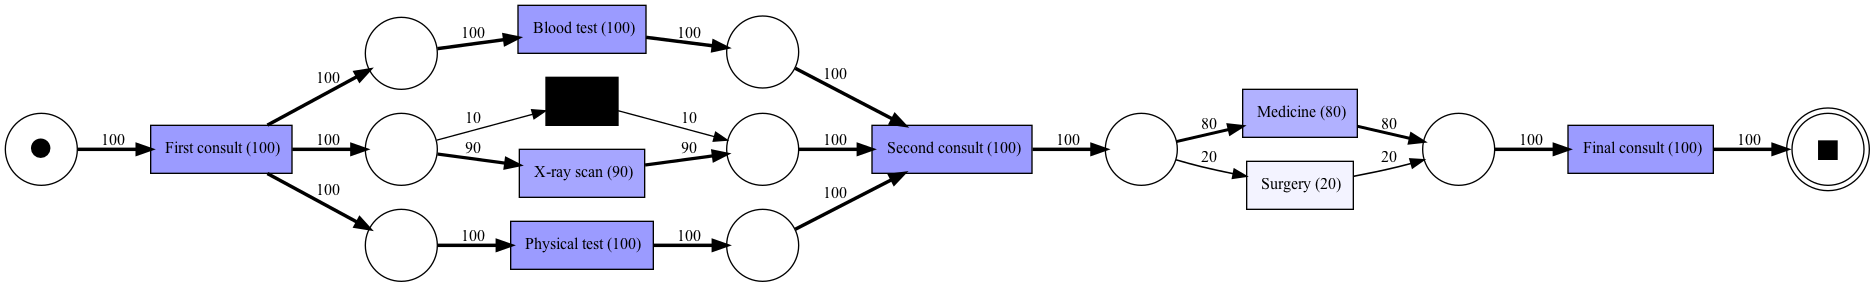

In [12]:
from pm4py.objects.conversion.process_tree import converter as pt_converter
from pm4py.visualization.petri_net import visualizer as pt_visualiser
petri_net, initial_marking, final_marking = pt_converter.apply(process_tree)
graph_visualisation = pt_visualiser.apply(petri_net, initial_marking, final_marking, variant=pt_visualiser.Variants.FREQUENCY, log=log)
pt_visualiser.view(graph_visualisation)
pt_visualiser.save(graph_visualisation, 'PetriNet.png')

It is important to consider how the found model differ from the directly-follows graph of events and event transitions to better grasp what the process model are including and excluding.

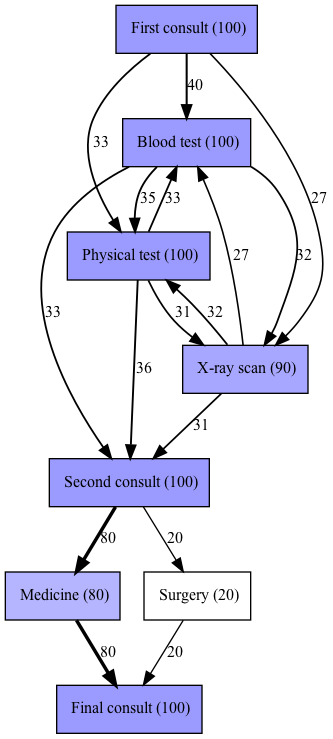

In [13]:
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery
from pm4py.visualization.dfg import visualizer as dfg_visualiser
dfg = dfg_discovery.apply(log)
graph_visualisation = dfg_visualiser.apply(dfg, log=log, variant=dfg_visualiser.Variants.FREQUENCY)
dfg_visualiser.view(graph_visualisation)
dfg_visualiser.save(graph_visualisation, 'DirectlyFollowsGraph.png')

As can be seen, the inductive miner failed to catch small loops, such as those between physical tests and blood tests.